# 1. Introduction

This notebook introduces image classification using Convolutional Neural Networks (CNNs) with the PyTorch library, offering a hands-on understanding of key aspects of building, training, and evaluating CNN models. While other libraries like TensorFlow and Keras are available, PyTorch is chosen for its intuitive interface and robust ecosystem.

# 2. Loading and Normalizing Dataset

The CIFAR-10 dataset, a widely used benchmark dataset for image classification will be used in this notebook. It consists of 60,000 color images, each 32x32 pixels, divided into 10 classes such as airplanes, cars, birds, and cats. The dataset is already pre-split into 50,000 training images and 10,000 test images, making it convenient for experimentation. It is readily available in the PyTorch library through `torchvision.datasets`.

100%|██████████| 170M/170M [00:04<00:00, 35.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


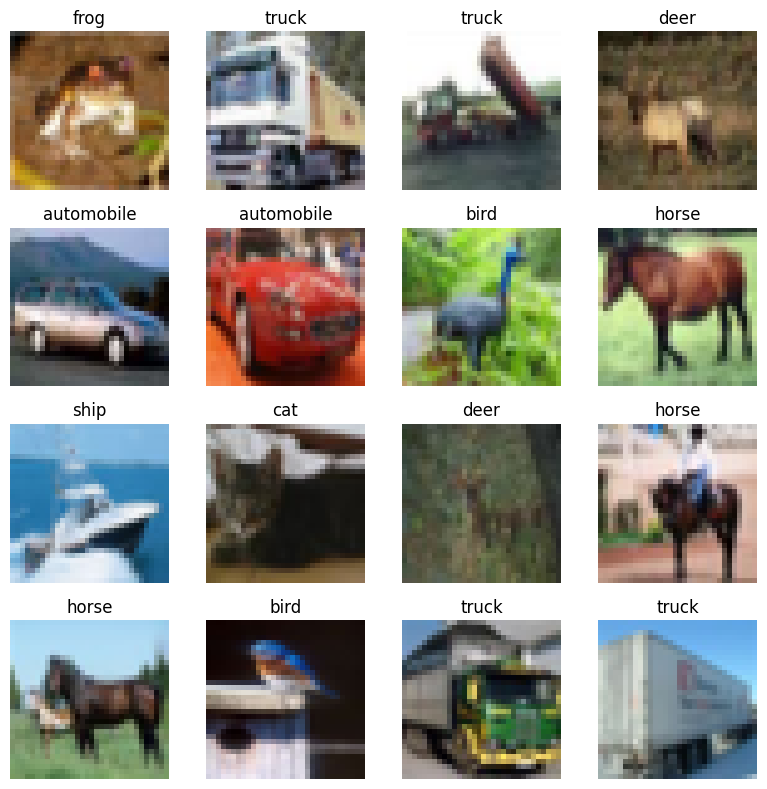

In [ ]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

batch_size = 64

# Define transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 dataset
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split dataset into train and validation
train_size = int(0.8 * len(cifar10_dataset))
val_size = len(cifar10_dataset) - train_size
train_dataset, val_dataset = random_split(cifar10_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Get class names
class_names = cifar10_dataset.classes

# Define a function to display a grid of images
def show_images(dataset, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()
    for i in range(num_images):
        # Get a random image and label from the dataset
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Rearrange dimensions to H x W x C for visualization

        # Unnormalize the image
        image = image * 0.5 + 0.5  # Assuming normalization was done with mean=0.5, std=0.5

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Show a grid of images
show_images(cifar10_dataset)


# 3. Defining training and evalution functions

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    # Training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total


    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total

    return train_loss, train_acc, val_loss, val_acc


In [ ]:
def evaluate_model(model, test_loader, criterion, device):
  # Test the model
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  all_labels = []
  all_predictions = []
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)

          test_loss += loss.item()
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

          all_labels.extend(labels.cpu().numpy())
          all_predictions.extend(predicted.cpu().numpy())

  test_acc = 100. * correct / total

  return test_loss, test_acc, all_labels, all_predictions

# 4. Training a CNN model from scratch

## 4.1. Define a CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 4.2. Define the model, loss function and optimizer

In [ ]:
import torch.optim as optim

learning_rate = 0.001

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 4.3. Train the network

In [ ]:
num_epochs = 10
# To store the best model
best_val_acc = 0
best_model_state = None

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  train_loss, train_acc, val_loss, val_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/10, Train Loss: 0.0027, Train Acc: 37.46%, Val Loss: 0.0095, Val Acc: 45.54%
Epoch 2/10, Train Loss: 0.0023, Train Acc: 48.60%, Val Loss: 0.0085, Val Acc: 51.05%
Epoch 3/10, Train Loss: 0.0021, Train Acc: 53.37%, Val Loss: 0.0081, Val Acc: 54.24%
Epoch 4/10, Train Loss: 0.0019, Train Acc: 56.54%, Val Loss: 0.0081, Val Acc: 55.38%
Epoch 5/10, Train Loss: 0.0018, Train Acc: 59.02%, Val Loss: 0.0075, Val Acc: 58.17%
Epoch 6/10, Train Loss: 0.0018, Train Acc: 60.90%, Val Loss: 0.0074, Val Acc: 59.24%
Epoch 7/10, Train Loss: 0.0017, Train Acc: 62.70%, Val Loss: 0.0074, Val Acc: 59.21%
Epoch 8/10, Train Loss: 0.0016, Train Acc: 63.87%, Val Loss: 0.0072, Val Acc: 60.12%
Epoch 9/10, Train Loss: 0.0016, Train Acc: 65.48%, Val Loss: 0.0070, Val Acc: 62.00%
Epoch 10/10, Train Loss: 0.0015, Train Acc: 66.59%, Val Loss: 0.0069, Val Acc: 61.86%


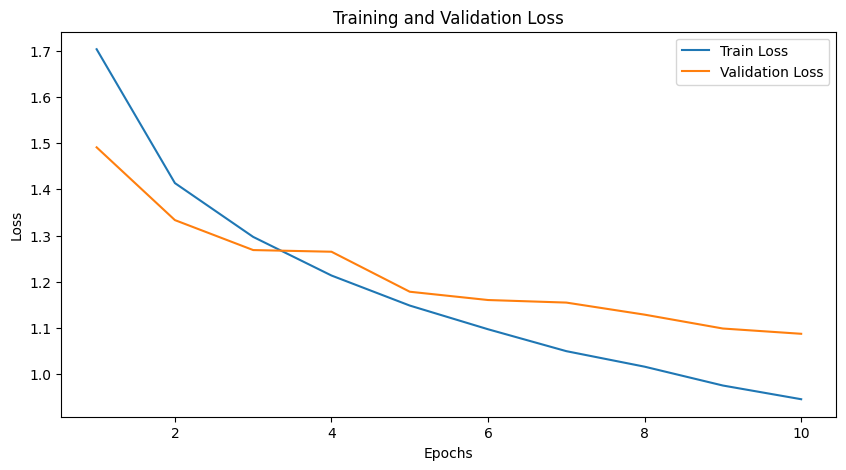

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 4.4. Evaluate the model on test data

In [ ]:
# Load the best model
model.load_state_dict(best_model_state)

# Test the model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {test_acc:.2f}%")

Test Loss: 1.0809, Test Acc: 61.74%


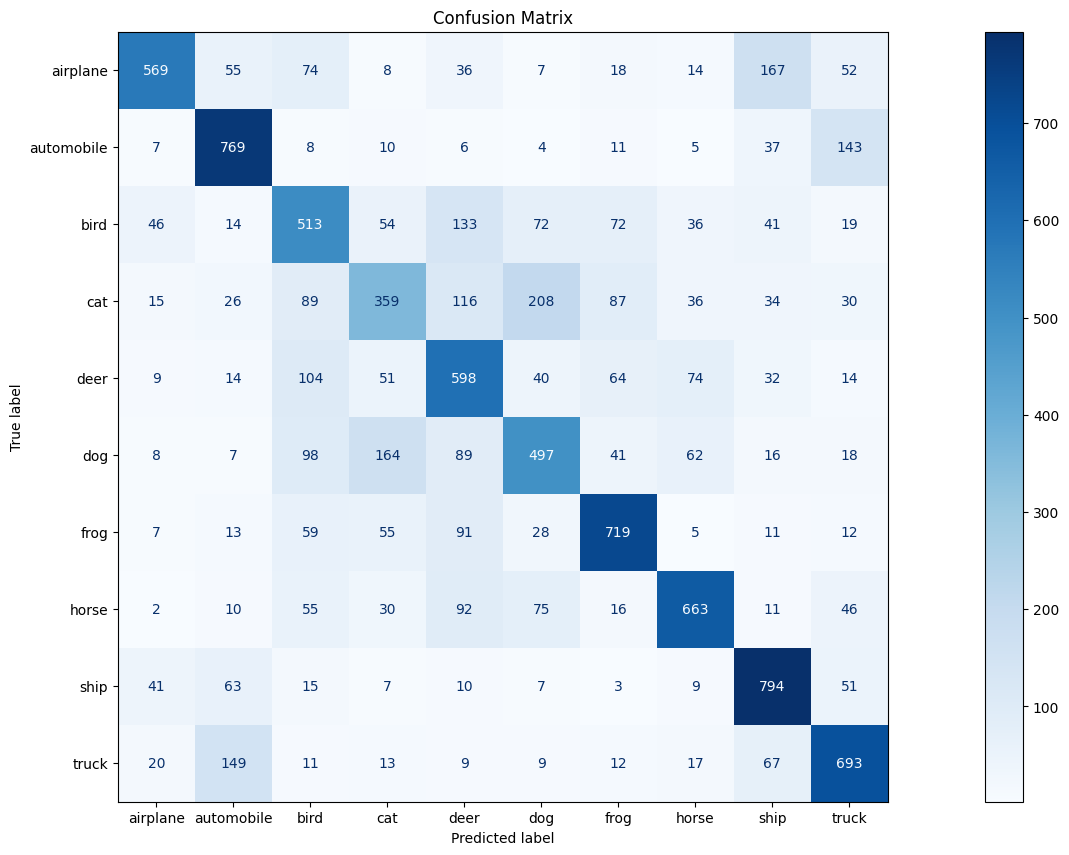

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
classes = cifar10_dataset.classes
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(25, 10))  # Adjust the width and height

disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.title('Confusion Matrix')
plt.show()


# 5. Transfer Learning: Fine-Tuning ResNet-18 Pretrained on ImageNet

In [ ]:
import torch.optim as optim

learning_rate = 0.001

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained ResNet-18 model
resnet18_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# Modify the final layer to fit CIFAR-10 (10 classes)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 10)
resnet18_model = resnet18_model.to(device)


# Initialize model, loss function, and optimizer
resnet18_model = resnet18_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.3MB/s]


In [ ]:
num_epochs = 10
# To store the best model
best_val_acc = 0
best_model_state = None

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  train_loss, train_acc, val_loss, val_acc = train_one_epoch(resnet18_model, train_loader, criterion, optimizer, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = resnet18_model.state_dict()

  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/10, Train Loss: 0.0016, Train Acc: 66.39%, Val Loss: 0.0054, Val Acc: 71.30%
Epoch 2/10, Train Loss: 0.0011, Train Acc: 77.68%, Val Loss: 0.0043, Val Acc: 76.95%
Epoch 3/10, Train Loss: 0.0009, Train Acc: 82.07%, Val Loss: 0.0038, Val Acc: 79.65%
Epoch 4/10, Train Loss: 0.0007, Train Acc: 85.27%, Val Loss: 0.0046, Val Acc: 77.15%
Epoch 5/10, Train Loss: 0.0006, Train Acc: 88.34%, Val Loss: 0.0038, Val Acc: 80.56%
Epoch 6/10, Train Loss: 0.0004, Train Acc: 90.72%, Val Loss: 0.0042, Val Acc: 79.60%
Epoch 7/10, Train Loss: 0.0003, Train Acc: 92.67%, Val Loss: 0.0041, Val Acc: 81.06%
Epoch 8/10, Train Loss: 0.0003, Train Acc: 93.78%, Val Loss: 0.0045, Val Acc: 80.17%
Epoch 9/10, Train Loss: 0.0003, Train Acc: 94.70%, Val Loss: 0.0046, Val Acc: 80.36%
Epoch 10/10, Train Loss: 0.0002, Train Acc: 95.45%, Val Loss: 0.0050, Val Acc: 79.56%


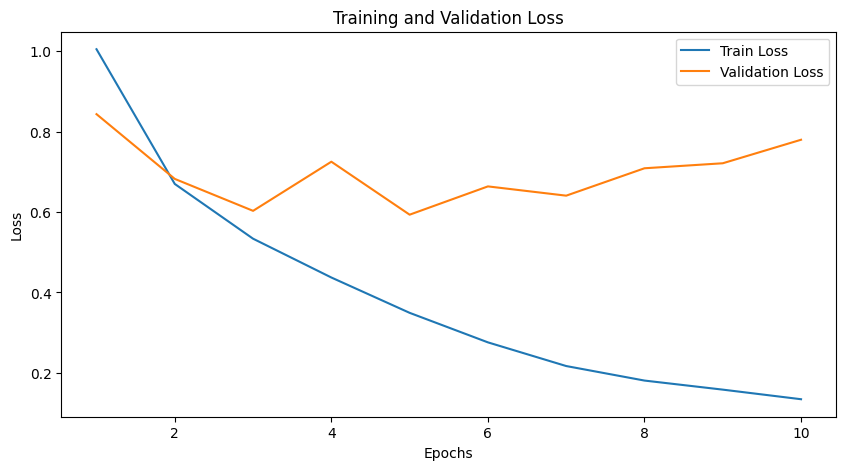

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Load the best model
resnet18_model.load_state_dict(best_model_state)

# Test the model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(resnet18_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {test_acc:.2f}%")

Test Loss: 0.8373, Test Acc: 78.21%


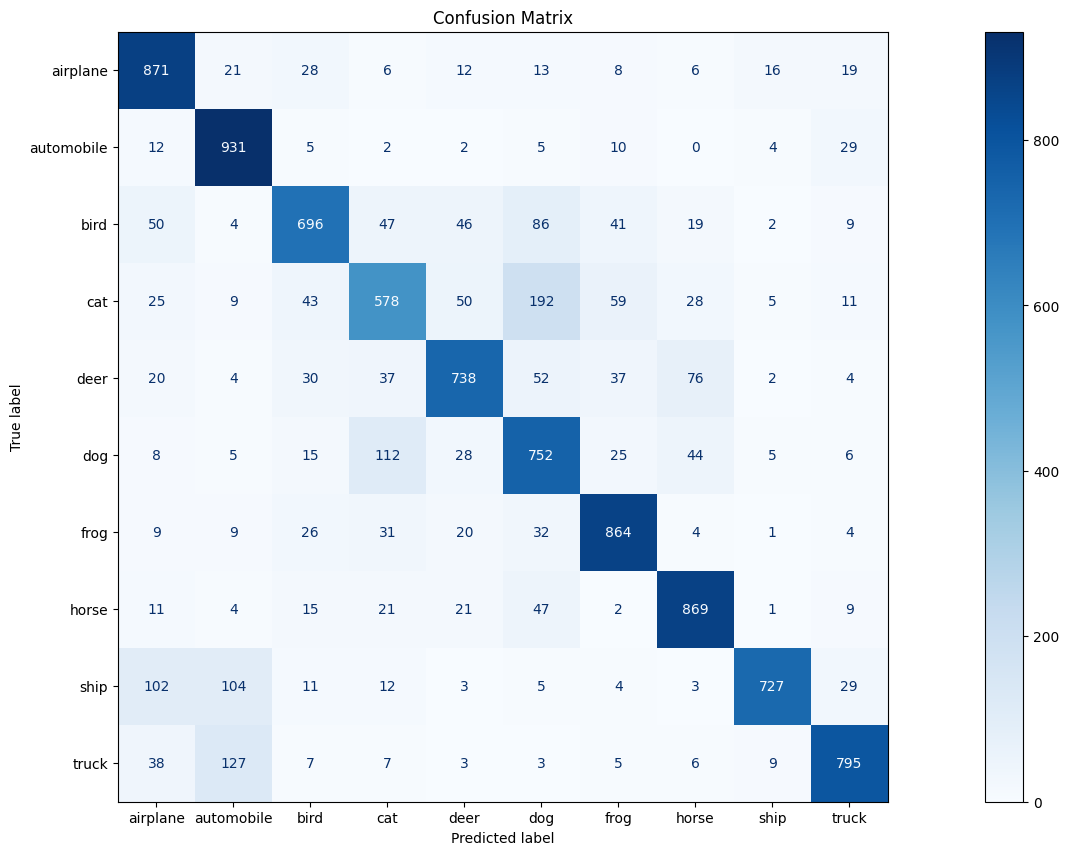

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
classes = cifar10_dataset.classes
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(25, 10))  # Adjust the width and height

disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.title('Confusion Matrix')
plt.show()


# 6. Augmentation

In [ ]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load pretrained ResNet-18 model
resnet18_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
# Modify the final layer to fit CIFAR-10 (10 classes)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 10)
resnet18_model = resnet18_model.to(device)


# Initialize model, loss function, and optimizer
resnet18_model = resnet18_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=learning_rate)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
num_epochs = 10
# To store the best model
best_val_acc = 0
best_model_state = None

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  train_loss, train_acc, val_loss, val_acc = train_one_epoch(resnet18_model, train_loader, criterion, optimizer, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = resnet18_model.state_dict()

  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/10, Train Loss: 0.0018, Train Acc: 51.65%, Val Loss: 0.0065, Val Acc: 64.99%
Epoch 2/10, Train Loss: 0.0014, Train Acc: 62.60%, Val Loss: 0.0059, Val Acc: 71.12%
Epoch 3/10, Train Loss: 0.0013, Train Acc: 65.27%, Val Loss: 0.0055, Val Acc: 70.23%
Epoch 4/10, Train Loss: 0.0012, Train Acc: 68.24%, Val Loss: 0.0107, Val Acc: 68.76%
Epoch 5/10, Train Loss: 0.0012, Train Acc: 69.06%, Val Loss: 0.0048, Val Acc: 74.96%
Epoch 6/10, Train Loss: 0.0011, Train Acc: 70.96%, Val Loss: 0.0045, Val Acc: 76.35%
Epoch 7/10, Train Loss: 0.0010, Train Acc: 72.30%, Val Loss: 0.0041, Val Acc: 78.99%
Epoch 8/10, Train Loss: 0.0010, Train Acc: 72.39%, Val Loss: 0.0041, Val Acc: 77.61%
Epoch 9/10, Train Loss: 0.0010, Train Acc: 73.67%, Val Loss: 0.0058, Val Acc: 74.39%
Epoch 10/10, Train Loss: 0.0010, Train Acc: 73.72%, Val Loss: 0.0038, Val Acc: 79.69%


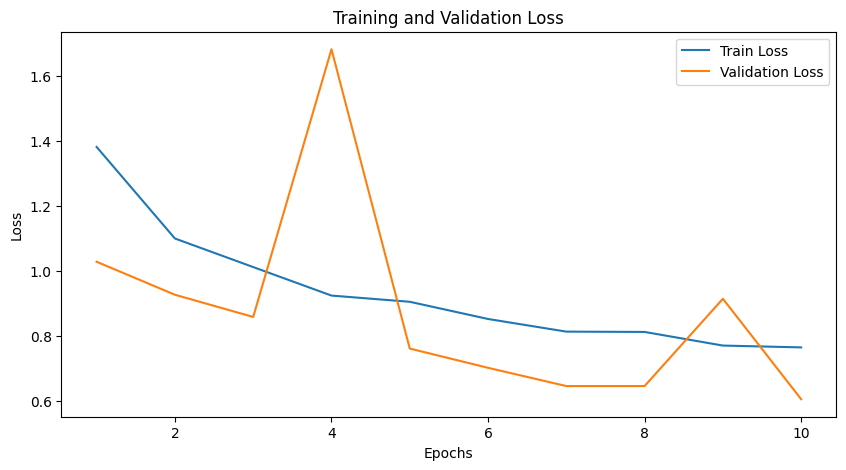

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Load the best model
resnet18_model.load_state_dict(best_model_state)

# Test the model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(resnet18_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {test_acc:.2f}%")

Test Loss: 0.6042, Test Acc: 79.69%


In [ ]:
# Load the best model
resnet18_model.load_state_dict(best_model_state)

# Test the model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(resnet18_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {test_acc:.2f}%")

Test Loss: 0.6042, Test Acc: 79.69%


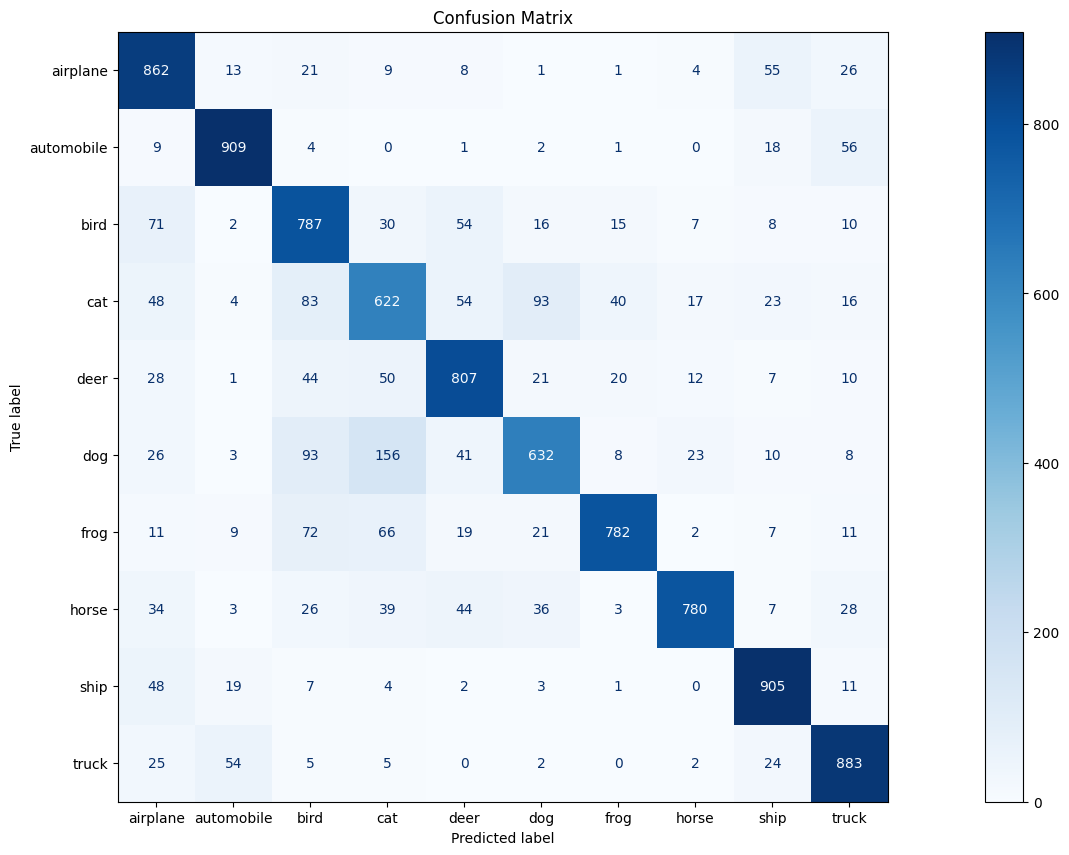

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
classes = cifar10_dataset.classes
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(25, 10))  # Adjust the width and height

disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.title('Confusion Matrix')
plt.show()


# 7. Dropout

In [ ]:
import torch.nn as nn
import torchvision
# Load pretrained ResNet-18 model with added Dropout
class ResNet18WithDropout(nn.Module):
    def __init__(self, original_model, num_classes, dropout_p=0.5):
        super(ResNet18WithDropout, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Exclude the original FC layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_p),  # Add Dropout layer
            nn.Linear(original_model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x

# Instantiate the modified model
original_resnet18 = torchvision.models.resnet18(pretrained=True)
model_with_dropout = ResNet18WithDropout(original_resnet18, num_classes=10, dropout_p=0.5)
model_with_dropout = model_with_dropout.to(device)

# Initialize loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_dropout.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 10
# To store the best model
best_val_acc = 0
best_model_state = None

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  train_loss, train_acc, val_loss, val_acc = train_one_epoch(model_with_dropout, train_loader, criterion, optimizer, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model_with_dropout.state_dict()

  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/10, Train Loss: 0.0019, Train Acc: 48.47%, Val Loss: 0.0069, Val Acc: 62.37%
Epoch 2/10, Train Loss: 0.0015, Train Acc: 60.12%, Val Loss: 0.0055, Val Acc: 70.44%
Epoch 3/10, Train Loss: 0.0014, Train Acc: 63.49%, Val Loss: 0.0057, Val Acc: 70.26%
Epoch 4/10, Train Loss: 0.0013, Train Acc: 66.15%, Val Loss: 0.0059, Val Acc: 68.90%
Epoch 5/10, Train Loss: 0.0012, Train Acc: 67.54%, Val Loss: 0.0053, Val Acc: 72.18%
Epoch 6/10, Train Loss: 0.0012, Train Acc: 69.21%, Val Loss: 0.0047, Val Acc: 75.33%
Epoch 7/10, Train Loss: 0.0011, Train Acc: 69.42%, Val Loss: 0.0045, Val Acc: 76.42%
Epoch 8/10, Train Loss: 0.0013, Train Acc: 66.54%, Val Loss: 0.0048, Val Acc: 76.86%
Epoch 9/10, Train Loss: 0.0011, Train Acc: 69.62%, Val Loss: 0.0041, Val Acc: 77.61%
Epoch 10/10, Train Loss: 0.0011, Train Acc: 70.92%, Val Loss: 0.0042, Val Acc: 77.46%


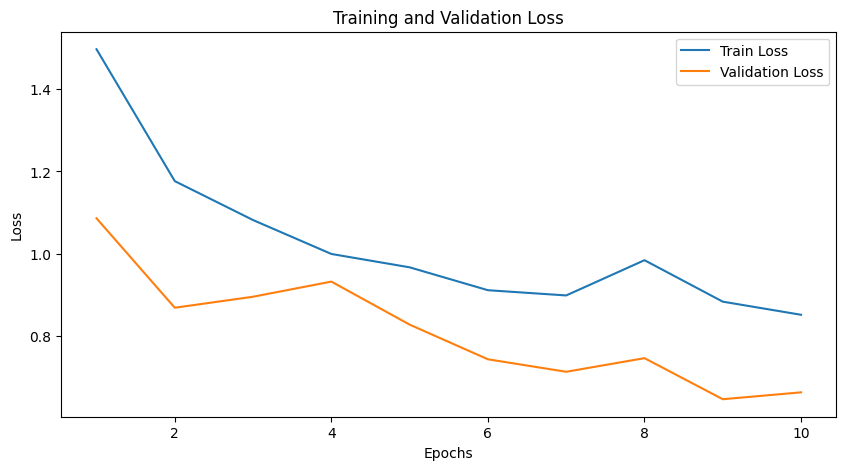

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Load the best model
model_with_dropout.load_state_dict(best_model_state)

# Test the model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(model_with_dropout, test_loader, criterion, device)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {test_acc:.2f}%")

Test Loss: 0.6637, Test Acc: 77.46%


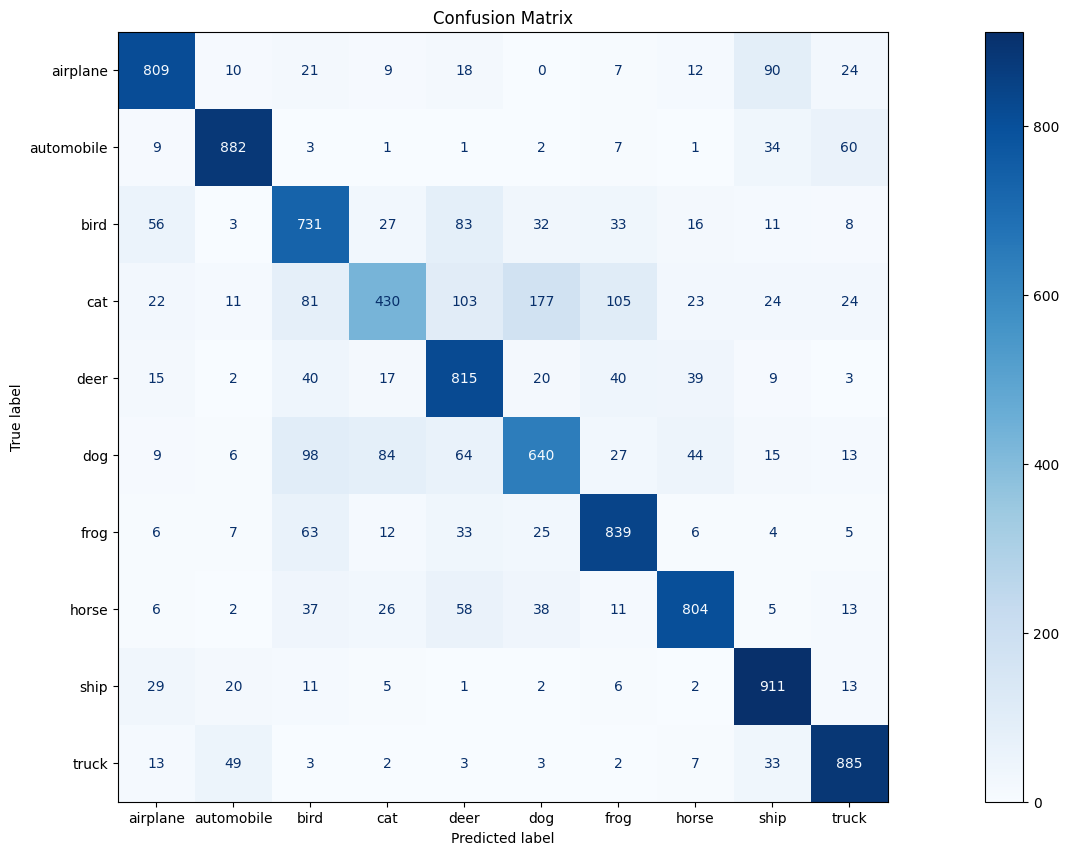

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
classes = cifar10_dataset.classes
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(25, 10))  # Adjust the width and height

disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.title('Confusion Matrix')
plt.show()
